### Marker genes

In [1]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

DEVICE = torch.device('cuda:0')

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext

In [2]:
ROOT_PATH = "/home/mehrtash/data"
CHECKPOINT_PATH = "/home/mehrtash/data/100M_long_run/run_001/lightning_logs/version_3/checkpoints/epoch=5-step=504000.ckpt"
REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_PATH,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient",
    verbose=False
)

In [12]:
# arguments
query_gene_ids = ctx.model_var_names
query_gene_symbols = list(map(ctx.gene_id_to_gene_symbol_map.get, query_gene_ids))

cell_1_dict = {
    'assay': "10x 3' v2",
    'suspension_type': "cell",
    'prompt_metadata_dict': {
        "disease": "normal",
        "sex": "male",
    },
    'total_mrna_umis': 10_000,
}


cell_2_dict = {
    'assay': "10x 3' v2",
    'suspension_type': "cell",
    'prompt_metadata_dict': {
        "cell_type": "CD8-positive, alpha-beta T cell",
        "tissue": "blood",
        "disease": "normal",
        "sex": "male",
    },
    'total_mrna_umis': 10_000,
}


In [13]:
query_chunk_size = 1_000
upper_percentile = 0.5
max_counts = 500
upper_pad = 1

gene_logits_1_nqk = ctx.get_gene_value_logits_by_metadata_chunked(
    assay=cell_1_dict['assay'],
    suspension_type=cell_1_dict['suspension_type'],
    prompt_metadata_dict=cell_1_dict['prompt_metadata_dict'],
    total_mrna_umis=cell_1_dict['total_mrna_umis'],
    query_gene_ids=query_gene_ids,
    query_chunk_size=query_chunk_size,
    max_counts=max_counts,
)

gene_logits_2_nqk = ctx.get_gene_value_logits_by_metadata_chunked(
    assay=cell_2_dict['assay'],
    suspension_type=cell_2_dict['suspension_type'],
    prompt_metadata_dict=cell_2_dict['prompt_metadata_dict'],
    total_mrna_umis=cell_2_dict['total_mrna_umis'],
    query_gene_ids=query_gene_ids,
    query_chunk_size=query_chunk_size,
    max_counts=max_counts,
)

Processing gene chunks:   0%|          | 0/37 [00:00<?, ?it/s]

Processing gene chunks:   0%|          | 0/37 [00:00<?, ?it/s]

In [14]:
def get_entropy(logits_qk: torch.Tensor) -> torch.Tensor:
    probs_qk = logits_qk.exp()
    assert torch.allclose(probs_qk.sum(dim=-1), torch.ones_like(probs_qk.sum(dim=-1)))
    entropy_q = -torch.sum(probs_qk * logits_qk, dim=-1)
    return entropy_q

entropy_1_q = get_entropy(gene_logits_1_nqk[0, :, :])
entropy_2_q = get_entropy(gene_logits_2_nqk[0, :, :])
delta_entropy_q = entropy_2_q - entropy_1_q

In [15]:
eps = 1e-8
mean_1_nq, std_1_nq = ctx.calculate_gene_mean_std_from_logits(gene_logits_1_nqk, max_counts)
mean_2_nq, std_2_nq = ctx.calculate_gene_mean_std_from_logits(gene_logits_2_nqk, max_counts)
lfc_q = torch.log2(mean_2_nq[0, ] + eps) - torch.log2(mean_1_nq[0, :] + eps)

In [16]:
log_equal_q = torch.logsumexp(gene_logits_1_nqk[0, :, :] + gene_logits_2_nqk[0, :, :], dim=-1)

In [17]:
log_pdf_1_qk = gene_logits_1_nqk[0, :, :]
log_pdf_2_qk = gene_logits_2_nqk[0, :, :]
log_cdf_1_qk = torch.logcumsumexp(log_pdf_1_qk, dim=-1)
log_cdf_2_qk = torch.logcumsumexp(log_pdf_2_qk, dim=-1)
log_prob_2_lt_1_q = torch.logsumexp(log_pdf_1_qk + log_cdf_2_qk, dim=-1)
log_prob_1_lt_2_q = torch.logsumexp(log_pdf_2_qk + log_cdf_1_qk, dim=-1)
log_pval_q = torch.where(lfc_q > 0, log_prob_2_lt_1_q, log_prob_1_lt_2_q)

In [18]:
kl_12_q = (log_pdf_1_qk.exp() * (log_pdf_1_qk - log_pdf_2_qk)).sum(-1)
kl_21_q = (log_pdf_2_qk.exp() * (log_pdf_2_qk - log_pdf_1_qk)).sum(-1)

Text(0.5, 1.0, 'CD8-positive, alpha-beta T cell vs. prior (male, normal)')

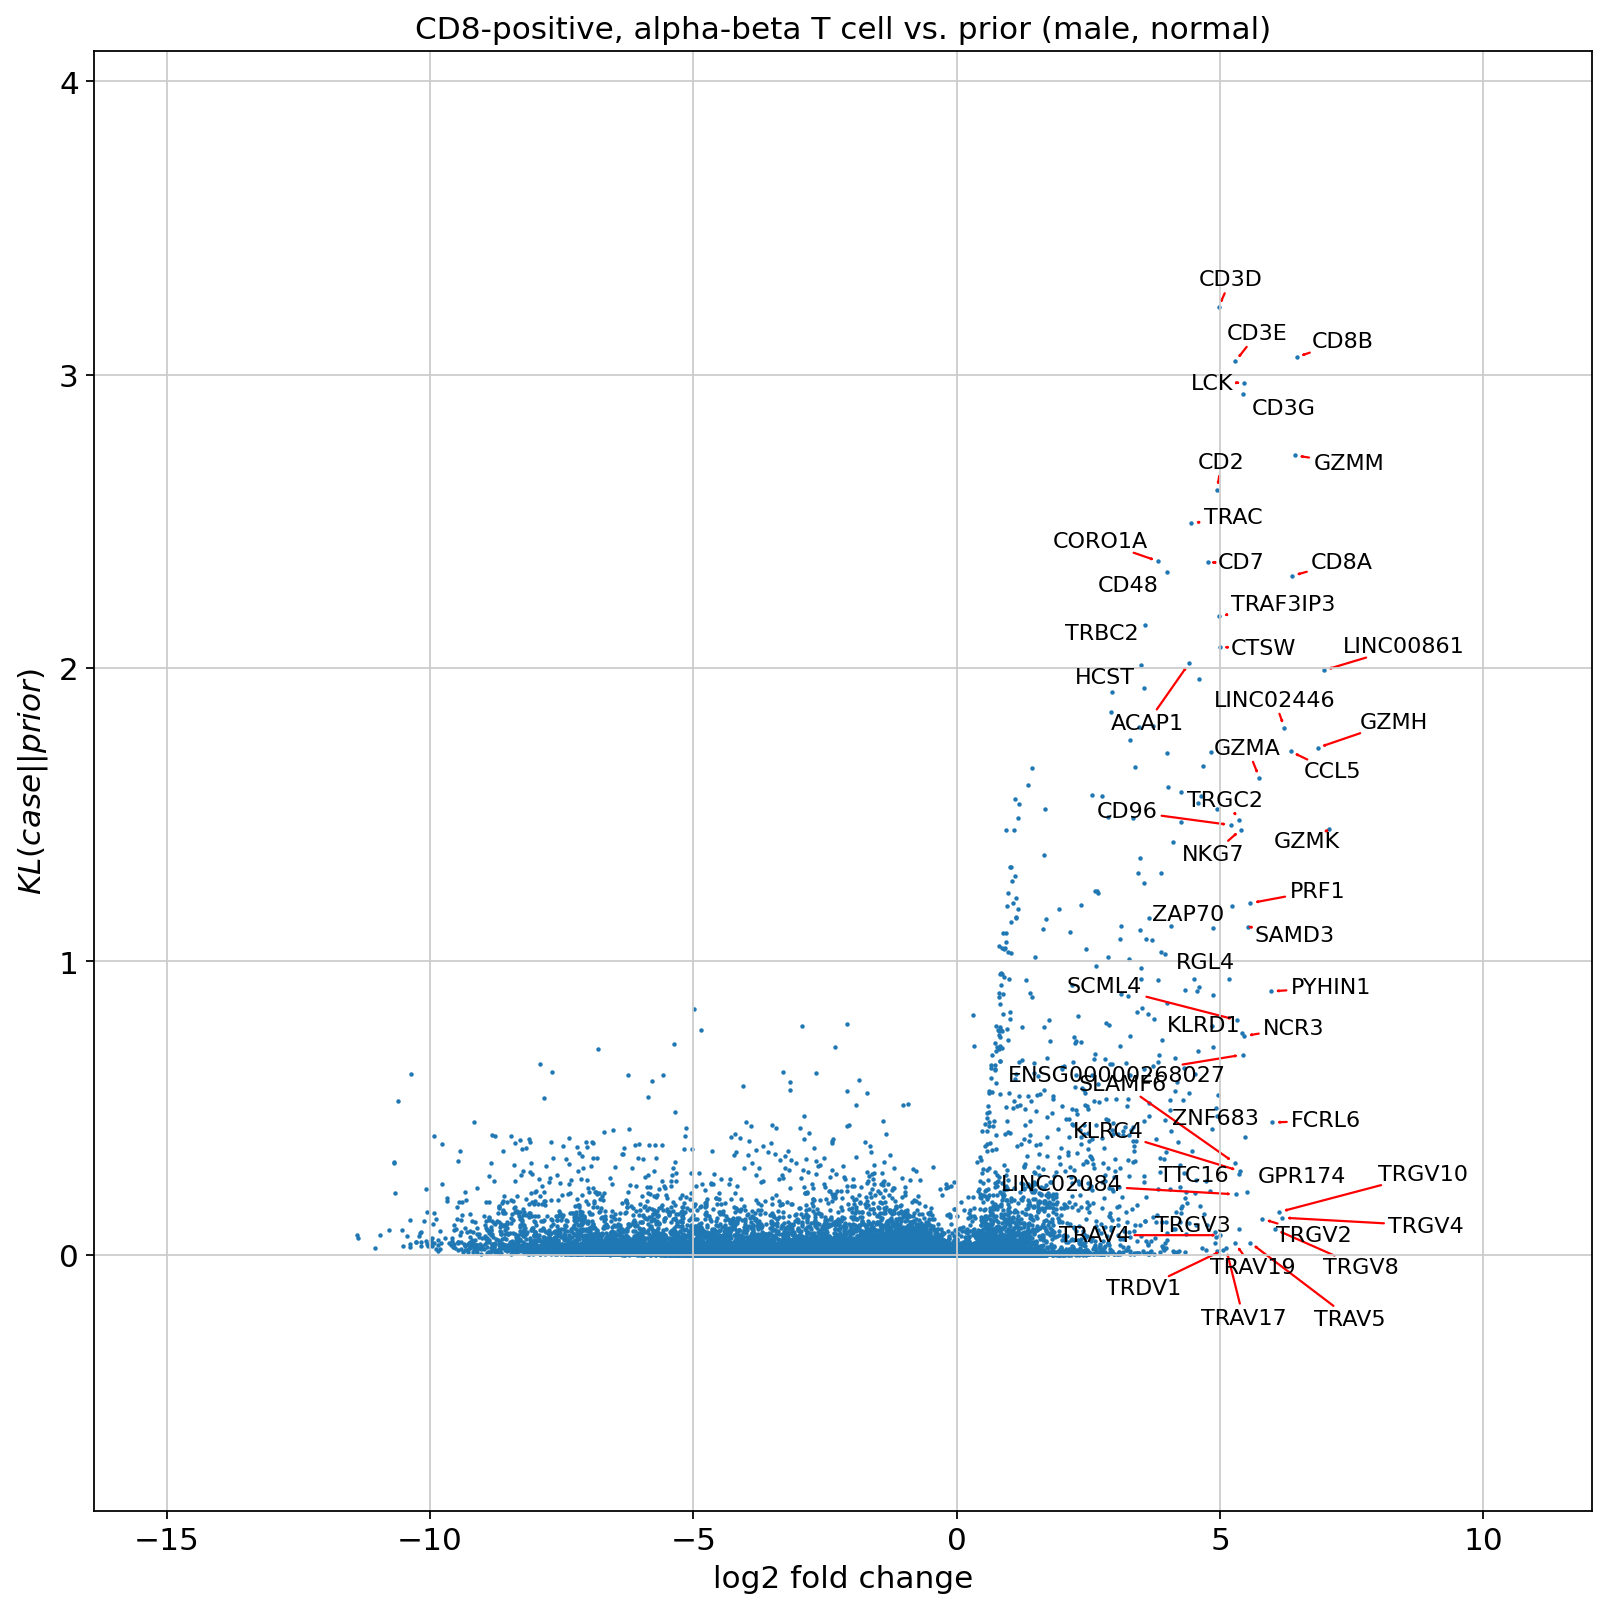

In [19]:
from adjustText import adjust_text

fig, ax  = plt.subplots(figsize=(12, 12))

x = lfc_q.cpu().numpy()
# y = -log_pval_q.cpu().numpy()
y = kl_21_q.cpu().numpy()

ax.scatter(
    x,
    y,
    s=1,
)

# increase xlim and ylim by 20% on both sides
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0] - 0.2 * (xlim[1] - xlim[0]), xlim[1] + 0.2 * (xlim[1] - xlim[0]))
ax.set_ylim(ylim[0] - 0.2 * (ylim[1] - ylim[0]), ylim[1] + 0.2 * (ylim[1] - ylim[0]))

mask = (y > 2)
mask = mask | (x > 5)
indices = np.where(mask)[0]

texts = [
    ax.text(
        x[i], y[i],
        query_gene_symbols[i],
        ha='center', va='center', fontsize=10)
    for i in indices
]

adjust_text(
    texts, expand=(1.2, 2),
    arrowprops=dict(arrowstyle='->', color='red') 
);

ax.set_xlabel("log2 fold change")
ax.set_ylabel("$KL(case || prior)$")
ax.set_title("CD8-positive, alpha-beta T cell vs. prior (male, normal)")


### Entropy experiments
(deprecated)

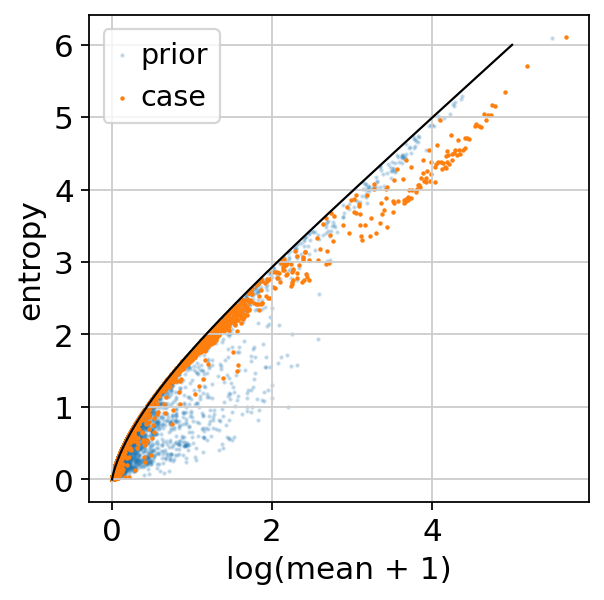

In [155]:
fig, ax = plt.subplots(figsize=(4, 4))

x1 = np.log1p(mean_1_nq[0, :].cpu().numpy())
y1 = entropy_1_q.cpu().numpy() 
x2 = np.log1p(mean_2_nq[0, :].cpu().numpy())
y2 = entropy_2_q.cpu().numpy() 

ax.scatter(
    x1, y1,
    s=1,
    alpha=0.2,
    label="prior",
)

ax.scatter(
    x2, y2,
    s=1,
    alpha=1,
    label="case",
)

# max entropy
def max_ent(mu):
    return (1 + mu) * np.log(1 + mu) - mu * np.log(mu)

xx = np.linspace(1e-6, 5, 1000)
yy = max_ent(np.exp(xx) - 1)

ax.plot(xx, yy, color='black', linestyle='-', linewidth=1)

# ax.set_xlim((0, 0.05))
# ax.set_ylim((0, 0.1))

ax.set_xlabel("log(mean + 1)")
ax.set_ylabel("entropy")

ax.legend()


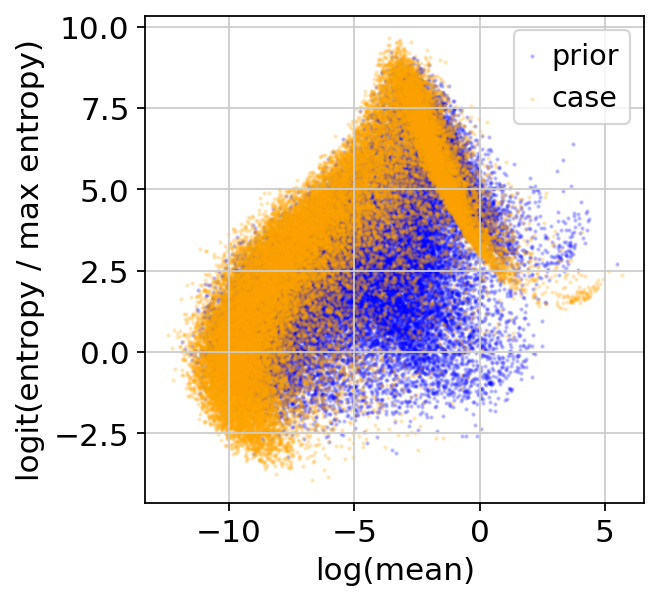

In [176]:
from scipy.special import xlogy

fig, ax = plt.subplots(figsize=(4, 4))

# max entropy
def max_ent(mu):
    return xlogy(mu + 1, mu + 1) - xlogy(mu, mu)

x1 = np.log(mean_1_nq[0, :].cpu().numpy())
y1 = entropy_1_q.cpu().numpy() 
x2 = np.log(mean_2_nq[0, :].cpu().numpy())
y2 = entropy_2_q.cpu().numpy() 

y1_max = max_ent(np.exp(x1))
y2_max = max_ent(np.exp(x2))

def logit(x):
    return np.log(x / (1 - x))

z1 = logit(y1 / y1_max)
z2 = logit(y2 / y2_max)

ax.scatter(
    x1, z1,
    s=1,
    alpha=0.2,
    label="prior",
    color='blue'
)

ax.scatter(
    x2, z2,
    s=1,
    alpha=0.2,
    label="case",
    color='orange'
)




# ax.set_xlim((0, 0.05))
# ax.set_ylim((0, 0.1))

ax.set_xlabel("log(mean)")
ax.set_ylabel("logit(entropy / max entropy)")

ax.legend()

# ax.set_xlim((0, 5))


In [177]:
import numpy as np
from scipy.stats import norm

def bin_and_zscore_with_neglogp(x1, z1, x2, z2, n_bins):
    """
    Bins the range of x1 into n_bins, computes the mean and standard deviation of z1 for points in each bin,
    and then z-scores z2 based on the bin that each x2 value falls into.
    Additionally, computes the two-sided p-value in negative log space (i.e., -log(p))
    for each z-scored value, working entirely in log space for improved precision.
    
    Parameters:
        x1 (np.ndarray): Covariate array for the first response.
        z1 (np.ndarray): Response array corresponding to x1.
        x2 (np.ndarray): Covariate array for the second response.
        z2 (np.ndarray): Response array corresponding to x2 (to be z-scored).
        n_bins (int): Number of bins to divide the range of x1.
        
    Returns:
        z2_zscored (np.ndarray): z-scored values of z2 based on the statistics computed from z1.
        neg_log_p (np.ndarray): The negative log of the two-sided p-values (i.e., -log(p)).
        bin_means (np.ndarray): Array of the means of z1 computed in each bin.
        bin_stds (np.ndarray): Array of the standard deviations of z1 computed in each bin.
        bin_edges (np.ndarray): The edges used for the bins.
    """
    # Define bin edges (equal-width bins from min(x1) to max(x1))
    bin_edges = np.linspace(np.min(x1), np.max(x1), n_bins + 1)
    
    # Initialize arrays to hold the mean and std for each bin
    bin_means = np.empty(n_bins)
    bin_stds  = np.empty(n_bins)
    
    # Compute bin statistics for z1 based on x1
    for i in range(n_bins):
        # For all but the last bin, include the left edge and exclude the right.
        # For the last bin, include both edges.
        if i < n_bins - 1:
            mask = (x1 >= bin_edges[i]) & (x1 < bin_edges[i+1])
        else:
            mask = (x1 >= bin_edges[i]) & (x1 <= bin_edges[i+1])
        
        if np.sum(mask) > 0:
            bin_means[i] = np.mean(z1[mask])
            bin_stds[i]  = np.std(z1[mask])
        else:
            # If no points fall in this bin, assign NaN.
            bin_means[i] = np.nan
            bin_stds[i]  = np.nan

    # Determine the bin index for each x2 using the same bin edges.
    # np.digitize returns indices in 1..n_bins, so subtract 1 for 0-indexed bins.
    bin_indices = np.digitize(x2, bin_edges, right=False) - 1

    # Prepare output arrays, defaulting to NaN.
    z2_zscored = np.full(z2.shape, np.nan)
    neg_log_p  = np.full(z2.shape, np.nan)
    
    # Identify valid x2 entries that fall within our bins.
    valid = (bin_indices >= 0) & (bin_indices < n_bins)
    valid_idx = np.where(valid)[0]  # indices of valid entries

    # For valid entries, check that the corresponding bin standard deviation is nonzero and not NaN.
    valid_std = (bin_stds[bin_indices[valid]] != 0) & (~np.isnan(bin_stds[bin_indices[valid]]))
    good_idx = valid_idx[valid_std]

    # Compute the z-scored values for valid entries.
    z2_zscored[good_idx] = (z2[good_idx] - bin_means[bin_indices[good_idx]]) / bin_stds[bin_indices[good_idx]]
    
    # Compute the two-sided p-values in log space.
    # Two-sided p-value: p = 2 * norm.sf(|z|)
    # Thus: log(p) = log(2) + norm.logsf(|z|)
    # And: -log(p) = -log(2) - norm.logsf(|z|)
    log_p = np.log(2) + norm.logsf(np.abs(z2_zscored[good_idx]))
    neg_log_p[good_idx] = -log_p
    
    return z2_zscored, neg_log_p, bin_means, bin_stds, bin_edges


In [178]:
z2_zscored, neg_log_p, bin_means, bin_stds, bin_edges = bin_and_zscore_with_neglogp(x1, z1, x2, z2, 20)

(-1.0, 20.0)

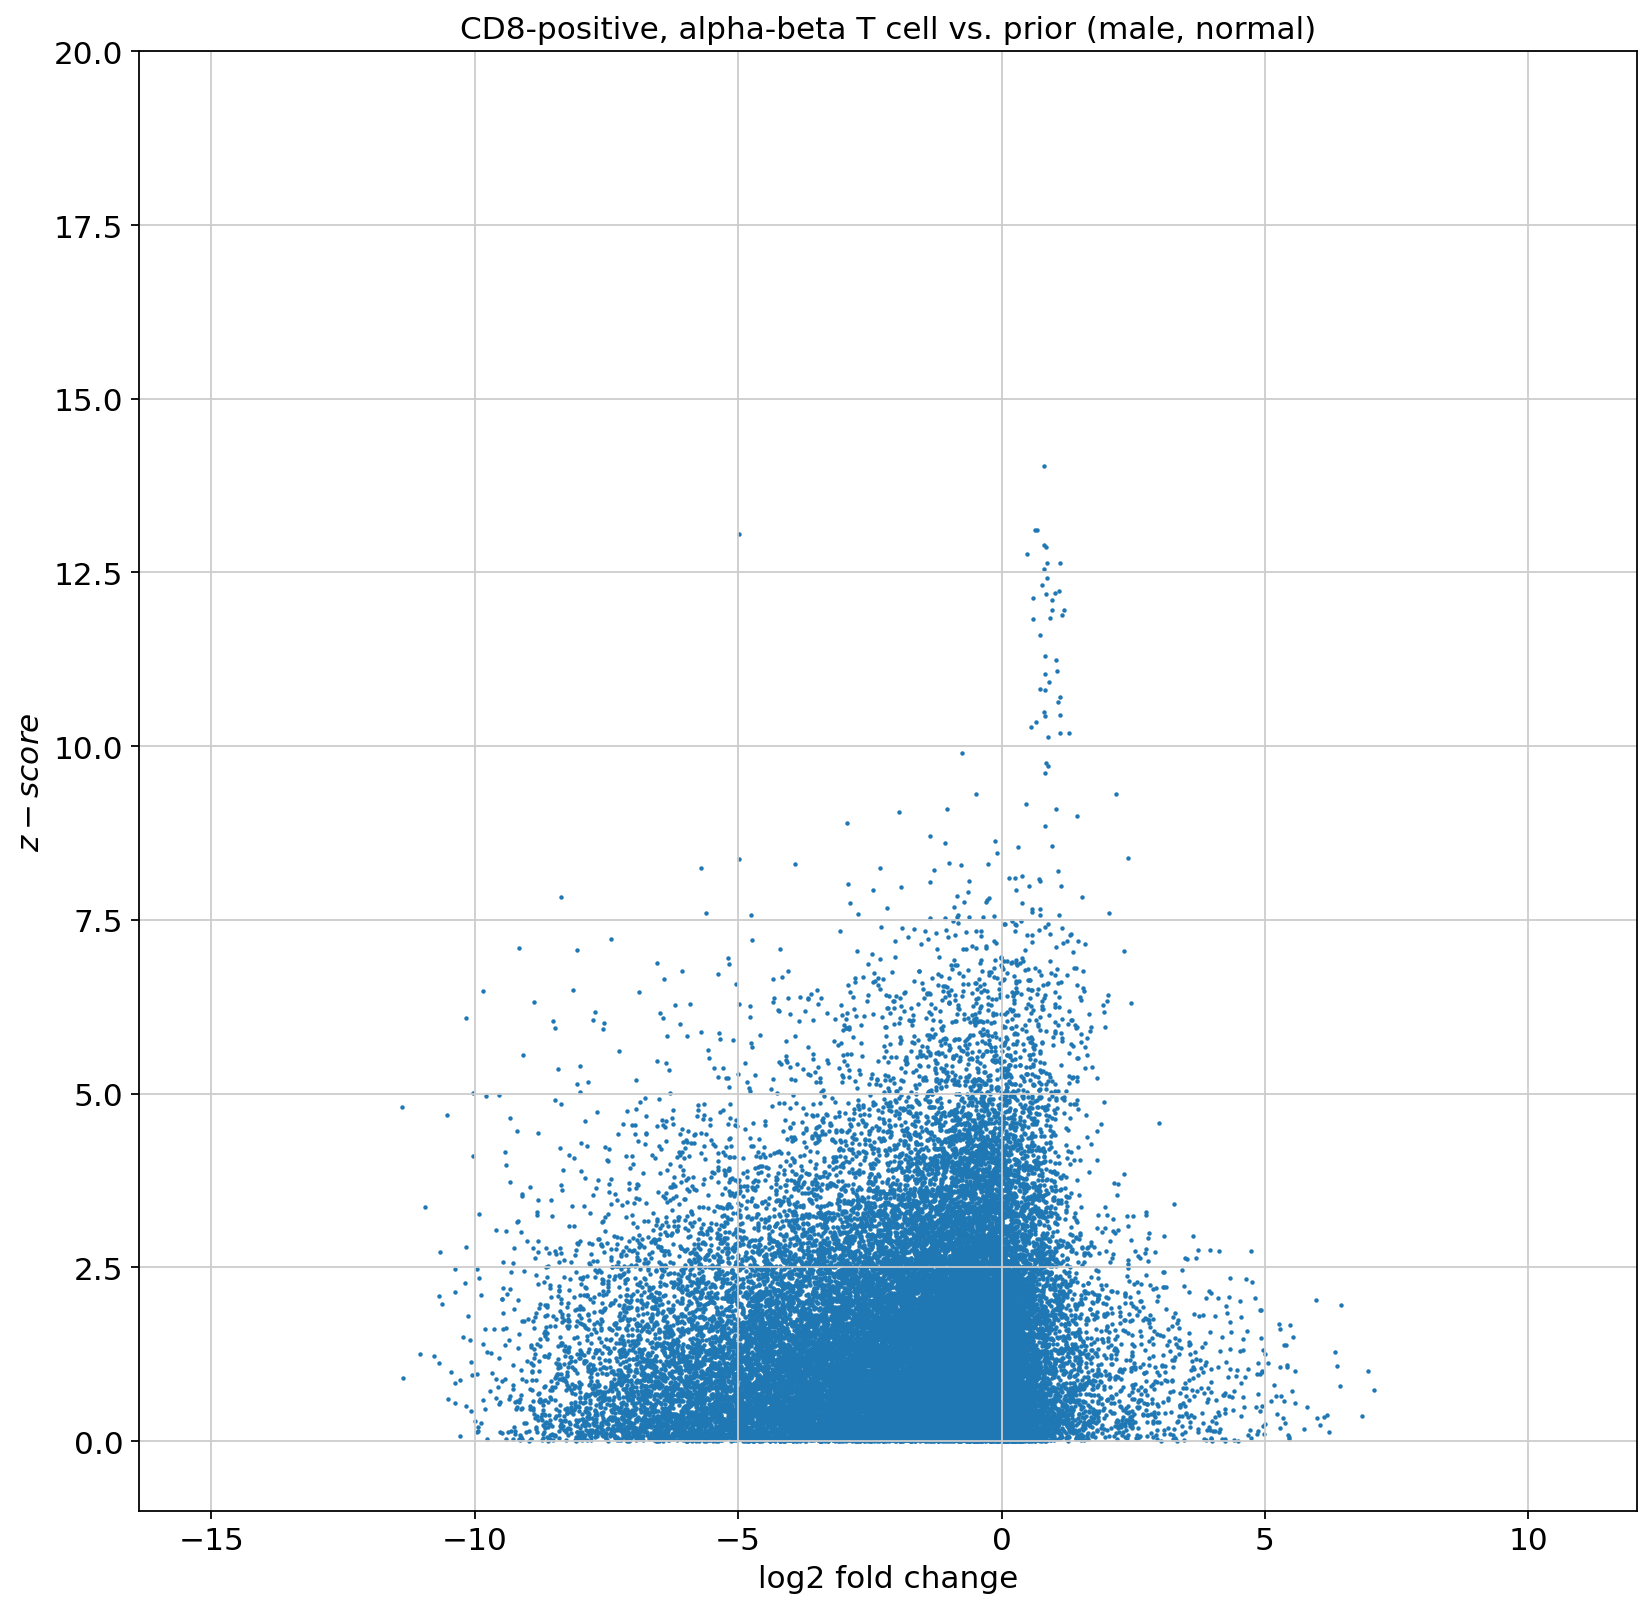

In [180]:
from adjustText import adjust_text

fig, ax  = plt.subplots(figsize=(12, 12))

x = lfc_q.cpu().numpy()
y = neg_log_p

ax.scatter(
    x,
    y,
    s=1,
)

# increase xlim and ylim by 20% on both sides
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0] - 0.2 * (xlim[1] - xlim[0]), xlim[1] + 0.2 * (xlim[1] - xlim[0]))
ax.set_ylim(ylim[0] - 0.2 * (ylim[1] - ylim[0]), ylim[1] + 0.2 * (ylim[1] - ylim[0]))


# mask = (y > 5) | (x > 5)
# indices = np.where(mask)[0]

# texts = [
#     ax.text(
#         x[i], y[i],
#         query_gene_symbols[i],
#         ha='center', va='center', fontsize=10)
#     for i in indices
# ]

# adjust_text(
#     texts, expand=(1.2, 2),
#     arrowprops=dict(arrowstyle='->', color='red') 
# );

ax.set_xlabel("log2 fold change")
ax.set_ylabel("$z-score$")
ax.set_title("CD8-positive, alpha-beta T cell vs. prior (male, normal)")

ax.set_ylim((-1, 20))
